## **SIMPLE PERCEPTRON**

## Introduction
This exercise uses a simple set of datapoints (randomly generated planar coordinates) as input to train a single `perceptron` object. After first generating a simple dataset which is *linearly separable*, the model uses these coordinates as input to a weighted sum function with binary output, indicating group 0 or group 1. Training the model corrects the weights using a `learning_rate` value within the `perceptron.fit()` method. The final model performs with total error rate of 0.02% after a single epoch of training. Code is based on chapter 2 of De Marchi & Mitchell (2019), but I have adapted the code and added detailed commentary to walk through the data generation and perceptron functionality for beginners. I think the simplified math and code on this example is very helpful and I hope it useful for other beginners.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

# initiate random seed so that our data is "reproducibly random"
np.random.seed(42)

## Create datasets
This code creates two normally distributed clusters of datapoints, given as simple graph coordinates. By using a normal distrubution and setting the median and std_deviation, we get two clusers of data focused in different areas of the graph but with some slight overlap.Note that we are using (x1, x2) as our coordinate inputs here rather that the normal coordinate labeling of (x, y). This is because our y_value will be the output of the classification function, that is whether the point is in group 0 or group 1. So: 

---
|point (x1, x2)|group (y)|
|---|---|
|(0.0, 0.1)|0|
|(0.1, 0.1)|0|
but:
|(0.5, 0.5)|1|
|(0.6, 0.6)|1|


See the plot of the data below for an illustration of the point clusters.

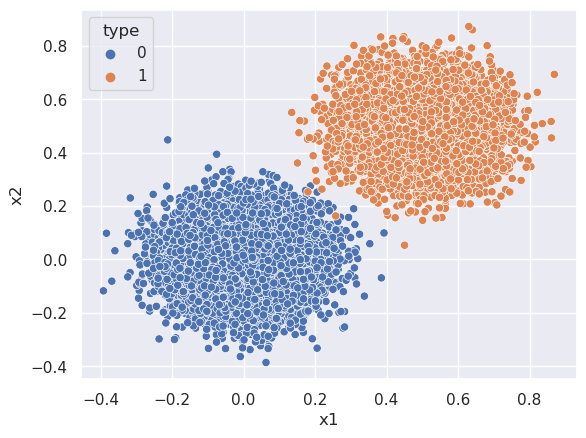

In [2]:
#### Create a dataset consisting of norrmally distributed coordinate points

# mean and standard deviation for coordinates of the clusters
median, std_deviation = 0, 0.1

# constant to shift the distribution for the second set
d2_shift = 0.5

# create the first distribution of 10,000 random points, using normal distribution
d1 = pd.DataFrame({'x1': np.random.normal(median, std_deviation, 10000),
                   'x2': np.random.normal(median, std_deviation, 10000),
                   'type': 0})

# create the second distribution of 1000 points using normal distribution
d2 = pd.DataFrame({'x1': np.random.normal(median, std_deviation, 10000) + d2_shift,
                   'x2': np.random.normal(median, std_deviation, 10000) + d2_shift,
                   'type': 1})

data = pd.concat([d1, d2], ignore_index=True)

# plot the full data set in seaborn, showing two groups
ax = sns.scatterplot(x="x1", y="x2", hue="type", data=data)

This creates two normally distributed clusters with a distinct linear shift of x2_mu_diff = .35 on each axis.

### Define the Perceptron class
Now we create a simple class `Perceptron` that accepts two inputs (i.e, the graph coordinates) and outputs a binary `0,1` for the datatype.
The `weighted_sum_of_inputs` method implements the weighted sums by multiplying each weight by the input values x1, x2.
The `output_function` method outputs 1 if z>=0.
The `predict` method predicts the group based on the test data and the weights in the preceptron model.


In [3]:
class Perceptron(object):
  """Simple implementation of the perceptron algorithm"""
  def __init__(self, w0=1, w1=0.1, w2=0.1):
    # weights of the perceptron
    self.w0 = w0 # bias
    self.w1 = w1
    self.w2 = w2

  def output_function(self, z):
    if z >= 0:
      return 1
    else:
      return 0

  def weighted_sum_of_inputs(self, x1, x2):
    return sum([1 * self.w0, x1 * self.w1, x2 * self.w2])

  def predict(self, x1, x2):
    """Uses the output function to determine output of the perceptron"""
    z = self.weighted_sum_of_inputs(x1, x2)
    return self.output_function(z)

  def predict_boundary(self, x):
    """Predicts the boundaries of the classifier"""
    return -(self.w1 * x + self.w0) / self.w2

  def fit(self, X, y, epochs=1, learning_rate=0.05, verbose=True):
    """Trains the model on the given dataset"""
    errors = []

    for epoch in range(epochs):
      error = 0
      for i in range(0, len(X.index)):
        x1, x2, target = X.values[i][0], X.values[i][1], y.values[i]

        # the weights are corrected by learning rate value by the difference between predicted and actual label
        correction = learning_rate * (target - self.predict(x1, x2))
        self.w1 += correction * x1
        self.w2 += correction * x2
        self.w0 += correction
        error += int(correction != 0.0)
      errors.append(error)  # logs error at each epoch
      if verbose:
        print('Epochs: {} - Error: {} - Errors from all epochs: {}'.format(epoch, error, errors))


## Perceptron Learning Rule
The training process, defined as the `perceptron.fit()` method above calculates the weight update by multiplying the learning rate (here, `step`) by the difference between the true value and the prediction. This weighted error is multiplied by each input and added to the corresponding weight.

If a problem is linearly separable, this learning rule can find a set of weights that solves the problem in a finite number of iterations.

## Splitting the data into testing/training sets
We always want to set apart some of our data, which the model never gets to see during training. 
Here we follow the standard of pulling about 80% for training and reserving 20% for testing. 

In [4]:
# # 80% of the data will be randomly selected for the training set
msk = np.random.rand(len(data)) < 0.8
train_x, train_y = data[['x1', 'x2']][msk], data.type[msk]

# Everything else will go inot the testing set
test_x, test_y = data[['x1', 'x2']][~msk], data.type[~msk]

## Initialize weights and run training
We set the initial wieght values of the `my_perceptron` instance and and run `my_perceptron.fit()` to adjust the weights using the training data set over a single epoch with a learning rate = 0.005. This means the adjustment to the weights will be a fraction of the difference between the expected output from the model and the actual label on the data.

Size of training data: 15996

Epochs: 0 - Error: 32 - Errors from all epochs: [32]


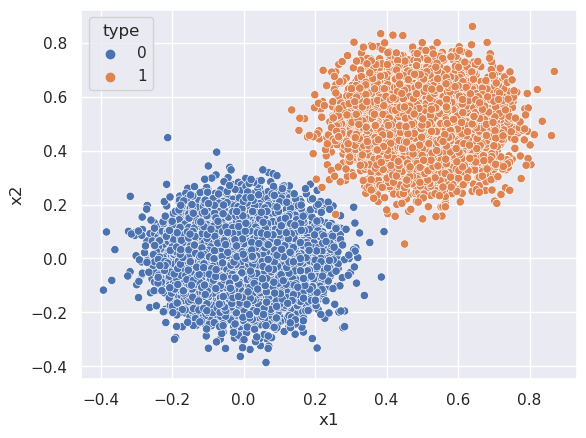

In [5]:
# initialize weights
my_perceptron = Perceptron(0.1, 0.1)

# plot test data
ax = sns.scatterplot(x="x1", y="x2", hue="type", data=data[msk])

# perform training on training set
print(f"Size of training data: {len(data[msk])}\n")
my_perceptron.fit(train_x, train_y, epochs=1, learning_rate=0.005, verbose=True)

## Check performance of the model
Now we make our predictions about the points of data based on their graph coordinates as input. We then lay out the results in a *confusion matrix*. The confusion matrix shows which points were correctly categorized and which were not. 
These results are then used to calculate total error rate for the test set.

In [6]:
pred_y = test_x.apply(lambda x: my_perceptron.predict(x.x1, x.x2), axis=1)
cm = confusion_matrix(test_y, pred_y, labels=[0, 1])

print(f"Size of training data: {len(data[~msk])}\n")
print(pd.DataFrame(cm,
                   index=['True 0', 'True 1'],
                   columns=['Predicted 0', 'Predicted 1']))
print(f"\nTotal Error = {(cm[0][1] + cm[1][0])/len(data[['x1', 'x2']][~msk])}")


Size of training data: 4004

        Predicted 0  Predicted 1
True 0         1984            1
True 1            0         2019

Total Error = 0.00024975024975024975


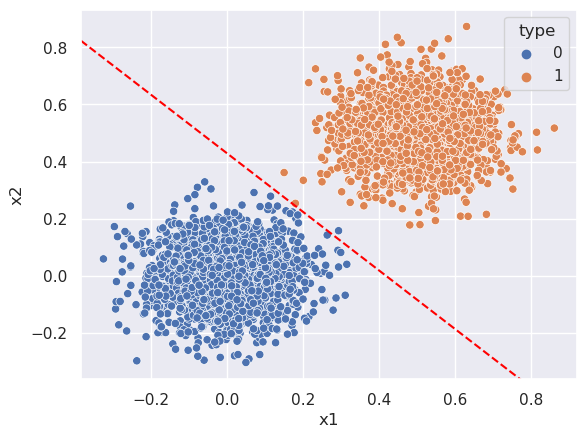

In [7]:
# Visualize the boundary
ax = sns.scatterplot(x="x1", y="x2", hue="type", data=data[~msk])
ax.autoscale(False)
x_vals = np.array(ax.get_xlim())
y_vals = my_perceptron.predict_boundary(x_vals)
ax.plot(x_vals, y_vals, '--', color="red")

## References

De Marchi, L & Mitchell L. (2019). *Hands-on neural networks*. Packt: Birmingham.